### Лабораторная работа №7 (Проведение исследований моделями семантической сегментации)

## 1. Выбор начальных условий

# a. Набор данных

Данные https://www.kaggle.com/datasets/sadhliroomyprime/football-semantic-segmentation/data

Данный датасет представляет собой набор данных для семантической сегментации футбольных сцен

Практическая обоснованность:Датасет ориентирован на сегментацию футбольных полей и объектов на них, что соответствует реальной задаче в области спортивного анализа, мониторинга матчей и автоматизированного распознавания объектов на спортивных полях.

In [1]:
!pip install kaggle

In [2]:
!pip install opendatasets
!pip install pandas

In [3]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/sadhliroomyprime/football-semantic-segmentation/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kirillzhur
Your Kaggle Key: ··········
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sadhliroomyprime/football-semantic-segmentation


In [5]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision
import random

path = "/content/football-semantic-segmentation/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
img_folder = os.path.join(path, "images")
file_path = sorted(os.listdir(img_folder))
print(len(file_path))

300


In [7]:
from pycocotools.coco import COCO
annFile = "{}/{}.json".format(path, "COCO_Football Pixel")
coco = COCO(annFile)

loading annotations into memory...
Done (t=0.95s)
creating index...
index created!


In [8]:
cats = coco.loadCats(coco.getCatIds())
cats

[{'id': 1393250,
  'name': 'Goal Bar',
  'supercategory': 'Goal Bar',
  'isthing': 1,
  'color': [98, 66, 21]},
 {'id': 1392807,
  'name': 'Referee',
  'supercategory': 'Referee',
  'isthing': 1,
  'color': [167, 64, 21]},
 {'id': 1392806,
  'name': 'Advertisements',
  'supercategory': 'Advertisements',
  'isthing': 1,
  'color': [166, 64, 21]},
 {'id': 1392805,
  'name': 'Ground',
  'supercategory': 'Ground',
  'isthing': 1,
  'color': [165, 64, 21]},
 {'id': 1392804,
  'name': 'Ball',
  'supercategory': 'Ball',
  'isthing': 1,
  'color': [164, 64, 21]},
 {'id': 1392803,
  'name': 'Coaches & Officials',
  'supercategory': 'Coaches & Officials',
  'isthing': 1,
  'color': [163, 64, 21]},
 {'id': 1392802,
  'name': 'Audience',
  'supercategory': 'Audience',
  'isthing': 1,
  'color': [162, 64, 21]},
 {'id': 1392801,
  'name': 'Goalkeeper B',
  'supercategory': 'Goalkeeper B',
  'isthing': 1,
  'color': [161, 64, 21]},
 {'id': 1392800,
  'name': 'Goalkeeper A',
  'supercategory': 'Goalke

In [9]:
nms = [cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
Goal Bar Referee Advertisements Ground Ball Coaches & Officials Audience Goalkeeper B Goalkeeper A Team B Team A

COCO supercategories: 
Ground Audience Goal Bar Ball Team A Advertisements Coaches & Officials Goalkeeper B Referee Team B Goalkeeper A


In [10]:
img_path = []
seg_path = []

for file in file_path:
    if 'fuse' in file:
        seg_path.append(file)
    elif 'save' in file:
        continue
    else:
        img_path.append(file)

assert len(seg_path) == len(img_path)
print(f"Number of data:", len(img_path))
print(f"Number of Seg image:", len(seg_path))

Number of data: 100
Number of Seg image: 100


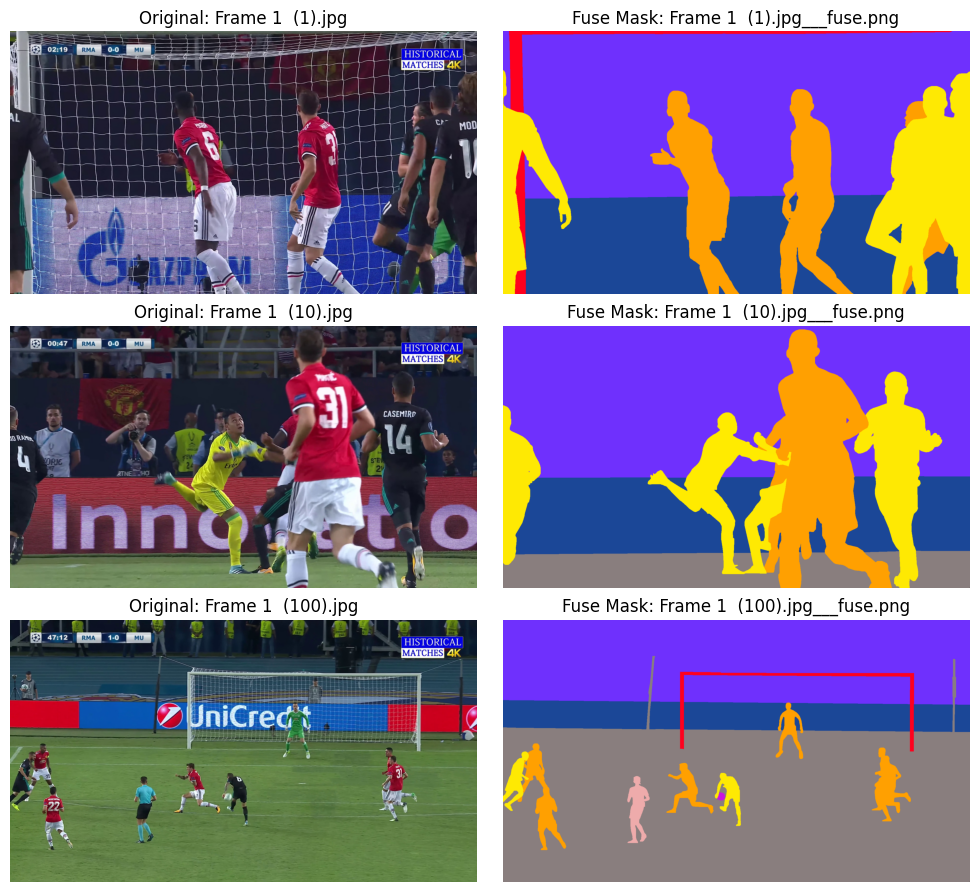

In [11]:
import cv2
import matplotlib.pyplot as plt

sample_image_pairs=[]
num_samples = 3
for img in img_path[:num_samples]:
    base_name = img.replace(".jpg", "")
    seg_sample = next((f for f in seg_path if base_name in f), None)

    if seg_sample:
        sample_image_pairs.append((img, seg_sample))

fig, axes = plt.subplots(num_samples, 2, figsize=(10, 3*num_samples))

for i, (img_file, seg_file) in enumerate(sample_image_pairs):
    img_sample = cv2.imread(os.path.join(img_folder, img_file))
    img_sample = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)

    seg_sample = cv2.imread(os.path.join(img_folder, seg_file))
    seg_sample = cv2.cvtColor(seg_sample, cv2.COLOR_BGR2RGB)

    axes[i, 0].imshow(img_sample)
    axes[i, 0].set_title(f"Original: {img_file}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(seg_sample)
    axes[i, 1].set_title(f"Fuse Mask: {seg_file}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

# b. Метрики качества


для данной задачи буду использовать следующие метрики:

Pixel Accuracy измеряет долю правильно классифицированных пикселей от общего числа пикселей: Определяется как отношение числа правильно классифицированных пикселей к общему количеству пикселей на изображении.

Intersection over Union (IoU) — IoU = Площадь пересечения / Площадь объединения.

Площадь пересечения — общая площадь, которую делят два ограничивающих прямоугольника (перекрытие).

Площадь объединения — общая площадь, которую охватывают два ограничивающих прямоугольника.

Результат вычисления по этой формуле — значение от 0 до 1, где 0 означает отсутствие перекрытия, а 1 — полное совпадение между предсказанным и фактическим расположением объекта.

## 2. Создание бейзлана и оценка качества

В качестве базовой модели будем использовать Unet с энкодером ResNet34, предобученным на ImageNet.

In [12]:
!pip install segmentation-models-pytorch albumentations --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [45]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

def get_unique_colors(img_folder, seg_files, max_classes=11):
    color_set = set()

    for seg_file in seg_files:
        seg_path = os.path.join(img_folder, seg_file)
        seg = cv2.imread(seg_path, cv2.IMREAD_COLOR)
        if seg is None:
            print(f"Warning: Could not read image file: {seg_path}")
            continue
        seg = cv2.cvtColor(seg, cv2.COLOR_BGR2RGB)
        unique_colors = np.unique(seg.reshape(-1,3), axis=0)

        for color in unique_colors:
            color_set.add(tuple(color))

            if len(color_set) >= max_classes:
                return list(color_set)

    return list(color_set)
unique_colors = get_unique_colors(img_folder, seg_path)
color_to_label = {color: idx for idx, color in enumerate(unique_colors)}
color_to_label

{(np.uint8(238), np.uint8(171), np.uint8(171)): 0,
 (np.uint8(254), np.uint8(233), np.uint8(3)): 1,
 (np.uint8(0), np.uint8(0), np.uint8(0)): 2,
 (np.uint8(255), np.uint8(0), np.uint8(29)): 3,
 (np.uint8(111), np.uint8(48), np.uint8(253)): 4,
 (np.uint8(137), np.uint8(126), np.uint8(126)): 5,
 (np.uint8(27), np.uint8(71), np.uint8(151)): 6,
 (np.uint8(255), np.uint8(160), np.uint8(1)): 7,
 (np.uint8(201), np.uint8(19), np.uint8(223)): 8,
 (np.uint8(255), np.uint8(159), np.uint8(0)): 9,
 (np.uint8(255), np.uint8(235), np.uint8(0)): 10}

In [46]:
import albumentations as A
from torchvision.transforms import v2

transforms = A.Compose([
    A.RandomResizedCrop((256, 256), (0.5, 1)),
    A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(0.3),
    A.VerticalFlip(0.2)
])

test_transforms = A.Compose([
    A.Resize(256,256),
])

In [13]:
class FootballData(torch.utils.data.Dataset):
    def __init__(self, img_path, seg_path, img_folder, color_to_label, transform=None):
        self.img_path = img_path
        self.seg_path = seg_path
        self.img_folder = img_folder
        self.transform = transform
        self.color_to_label = color_to_label

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        image_path, seg_path = self.img_path[idx], self.seg_path[idx]

        image = cv2.imread(os.path.join(img_folder, image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        seg=cv2.imread(os.path.join(img_folder, seg_path))
        seg=cv2.cvtColor(seg, cv2.COLOR_BGR2RGB)

        mask_class = np.zeros(seg.shape[:2], dtype=np.uint8)
        for color, label in self.color_to_label.items():
            mask_class[(seg == color).all(axis=-1)] = label

        if self.transform != None:
            augmented = self.transform(image=image, mask=mask_class)
            image, mask_class = augmented['image'], augmented['mask']

        image = torch.tensor(image).permute(2, 0, 1).float() / 255.0
        mask_class = torch.tensor(mask_class).long()

        return image, mask_class

In [47]:
train_dataset = FootballData(img_path, seg_path, img_folder, color_to_label, transform=transforms)
test_dataset = FootballData(img_path, seg_path, img_folder, color_to_label, transform=test_transforms)

train_size = int(0.8 * len(train_dataset))
temp_size = int(len(train_dataset) - train_size)
val_size = int(temp_size/2)

train_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, temp_size])
_, temp_dataset = torch.utils.data.random_split(test_dataset, [train_size, temp_size])

val_dataset, test_dataset = torch.utils.data.random_split(temp_dataset, [val_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=4,shuffle=True)

val_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1,shuffle=False, drop_last=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,shuffle=False, drop_last=False)

print(f"{len(train_dataset)} images divided into {len(train_loader)} batches")
print(f"{len(val_dataset)} images divided into {len(val_loader)} batches")


80 images divided into 20 batches
10 images divided into 10 batches


In [16]:
!pip install segmentation-models-pytorch

In [48]:
import segmentation_models_pytorch as smp
import torch

model = smp.Unet(
    encoder_name="resnet34",        # Используем ResNet34 в качестве энкодера
    encoder_weights="imagenet",       # Предобученные веса на ImageNet
    in_channels=3,                    # Входные каналы (RGB)
    classes=11,                       # Число классов
)

print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [49]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
num_epochs=40

In [50]:
def dice_score(pred, target, num_classes=11):
    smooth = 1e-6
    pred = pred.argmax(dim=1)
    dice = 0
    for i in range(num_classes):
        pred_f = (pred == i).float()
        target_f = (target == i).float()
        intersection = (pred_f * target_f).sum()
        dice += (2. * intersection + smooth) / (pred_f.sum() + target_f.sum() + smooth)
    return dice / num_classes

In [51]:
def calculate_iou(preds, targets, num_classes=11):
    ious = []
    for cls in range(num_classes):
        pred_cls = (preds == cls)
        target_cls = (targets == cls)
        intersection = (pred_cls & target_cls).sum().item()
        union = (pred_cls | target_cls).sum().item()
        if union == 0:
            continue
        ious.append(intersection / union)
    if len(ious) == 0:
        return 0.0
    return np.mean(ious)

def pixel_accuracy(preds, targets):
    correct = (preds == targets).sum().item()
    total = targets.numel()
    return correct / total

In [52]:
def train_model(model, train_loader, val_loader, criterion, optimizer, lr_scheduler=None, num_epochs=num_epochs, device=device):
    model = model.to(device)
    best_score = float('inf')
    best_params = None

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_dice = 0
        total_iou = 0
        total_pa = 0

        if lr_scheduler:
            current_lr = optimizer.param_groups[0]['lr']

        for i, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)

            masks = torch.clamp(masks, min=0, max=10).long()

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()


            dice = dice_score(outputs, masks)


            preds = torch.argmax(outputs, dim=1)
            iou = calculate_iou(preds, masks, num_classes=11)
            pa = pixel_accuracy(preds, masks)

            total_loss += loss.item()
            total_dice += dice.item()
            total_iou += iou
            total_pa += pa

        if lr_scheduler:
            lr_scheduler.step()

        avg_loss = total_loss / len(train_loader)
        avg_dice = total_dice / len(train_loader)
        avg_iou = total_iou / len(train_loader)
        avg_pa = total_pa / len(train_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f},  IoU: {avg_iou:.4f}, Pixel Acc: {avg_pa:.4f}")

        model.eval()
        val_total_loss = 0
        val_total_dice = 0
        val_total_iou = 0
        val_total_pa = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                masks = torch.clamp(masks, min=0, max=10).long()

                outputs = model(images)
                val_loss = criterion(outputs, masks)
                dice = dice_score(outputs, masks)

                preds = torch.argmax(outputs, dim=1)
                iou = calculate_iou(preds, masks, num_classes=11)
                pa = pixel_accuracy(preds, masks)

                val_total_loss += val_loss.item()
                val_total_dice += dice.item()
                val_total_iou += iou
                val_total_pa += pa

        val_avg_loss = val_total_loss / len(val_loader)
        val_avg_dice = val_total_dice / len(val_loader)
        val_avg_iou = val_total_iou / len(val_loader)
        val_avg_pa = val_total_pa / len(val_loader)
        print(f"Val Loss: {val_avg_loss:.4f}, IoU: {val_avg_iou:.4f}, Pixel Acc: {val_avg_pa:.4f}")

        '''if val_avg_loss < best_score:
            best_score = val_avg_loss
            best_params = model.state_dict()
            #print(f"Best Val Loss: {best_score:.4f} - Model parameters stored.")'''

In [29]:
model.to(device)

train_model(model, train_loader, val_loader, criterion, optimizer, lr_scheduler=None, num_epochs=10, device=device)

Epoch [1/10], Loss: 1.7514,  IoU: 0.1618, Pixel Acc: 0.5376
Val Loss: 1.6290, IoU: 0.1713, Pixel Acc: 0.6110
Epoch [2/10], Loss: 1.5641,  IoU: 0.2158, Pixel Acc: 0.6597
Val Loss: 1.3922, IoU: 0.2338, Pixel Acc: 0.7375
Epoch [3/10], Loss: 1.3363,  IoU: 0.2737, Pixel Acc: 0.7720
Val Loss: 1.2541, IoU: 0.2707, Pixel Acc: 0.7944
Epoch [4/10], Loss: 1.1967,  IoU: 0.2874, Pixel Acc: 0.7996
Val Loss: 1.0685, IoU: 0.2922, Pixel Acc: 0.8341
Epoch [5/10], Loss: 1.0715,  IoU: 0.3089, Pixel Acc: 0.8294
Val Loss: 0.9818, IoU: 0.3102, Pixel Acc: 0.8471
Epoch [6/10], Loss: 0.9628,  IoU: 0.3242, Pixel Acc: 0.8490
Val Loss: 0.8853, IoU: 0.3300, Pixel Acc: 0.8565
Epoch [7/10], Loss: 0.8543,  IoU: 0.3357, Pixel Acc: 0.8652
Val Loss: 0.8121, IoU: 0.3713, Pixel Acc: 0.8725
Epoch [8/10], Loss: 0.8022,  IoU: 0.3382, Pixel Acc: 0.8698
Val Loss: 0.7882, IoU: 0.3809, Pixel Acc: 0.8599
Epoch [9/10], Loss: 0.7504,  IoU: 0.3433, Pixel Acc: 0.8741
Val Loss: 0.6889, IoU: 0.4112, Pixel Acc: 0.8786
Epoch [10/10], Loss

## 3. Улучшение бейзлайна

для улучшение бейзлайна поменяем энкодер на resnet50, а также попробуем комбинировать Cross-Entropy Loss с Dice Loss, чтобы стабилизировать потери при обучении, поскольку так можно сбалансировать как точность по пикселям (Cross-Entropy Loss), так и пространственную согласованность (Dice Loss).

In [ ]:
model = smp.Unet(
    encoder_name="resnet50",        
    encoder_weights="imagenet",       
    in_channels=3,                  
    classes=11,                    
)

print(model)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 239MB/s]


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [31]:
def dice_loss(pred, target, num_classes=11):
    smooth = 1e-6
    pred = pred.argmax(dim=1)
    dice = 0
    for i in range(num_classes):
        pred_f = (pred == i).float()
        target_f = (target == i).float()
        intersection = (pred_f * target_f).sum()
        dice += (2. * intersection + smooth) / (pred_f.sum() + target_f.sum() + smooth)
    return dice / num_classes

def combined_loss(outputs, masks, ce_weight=0.5, dice_weight=0.5):

    ce = nn.CrossEntropyLoss()(outputs, masks)
    d = dice_loss(outputs, masks)
    return ce_weight * ce + dice_weight * d

In [41]:
def train_model(model, train_loader, val_loader, optimizer, lr_scheduler=None, num_epochs=50, device="cuda"):
    model = model.to(device)
    best_score = float('inf')
    best_params = None

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_dice = 0
        total_iou = 0
        total_pa = 0

        if lr_scheduler:
            current_lr = optimizer.param_groups[0]['lr']

        for i, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)
            masks = torch.clamp(masks, min=0, max=10).long()

            optimizer.zero_grad()

            outputs = model(images)
            loss = combined_loss(outputs, masks)
            loss.backward()
            optimizer.step()

            dice = dice_loss(outputs, masks)

            preds = torch.argmax(outputs, dim=1)
            iou = calculate_iou(preds, masks, num_classes=11)
            pa = pixel_accuracy(preds, masks)

            total_loss += loss.item()
            total_dice += dice.item()
            total_iou += iou
            total_pa += pa

        if lr_scheduler:
            lr_scheduler.step()

        avg_loss = total_loss / len(train_loader)
        avg_dice = total_dice / len(train_loader)
        avg_iou = total_iou / len(train_loader)
        avg_pa = total_pa / len(train_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}, Pixel Acc: {avg_pa:.4f}")

        model.eval()
        val_total_loss = 0
        val_total_dice = 0
        val_total_iou = 0
        val_total_pa = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                masks = torch.clamp(masks, min=0, max=10).long()

                outputs = model(images)
                val_loss = combined_loss(outputs, masks)
                dice = dice_loss(outputs, masks)

                preds = torch.argmax(outputs, dim=1)
                iou = calculate_iou(preds, masks, num_classes=11)
                pa = pixel_accuracy(preds, masks)

                val_total_loss += val_loss.item()
                val_total_dice += dice.item()
                val_total_iou += iou
                val_total_pa += pa

        val_avg_loss = val_total_loss / len(val_loader)
        val_avg_dice = val_total_dice / len(val_loader)
        val_avg_iou = val_total_iou / len(val_loader)
        val_avg_pa = val_total_pa / len(val_loader)
        print(f"Val Loss: {val_avg_loss:.4f}, IoU: {val_avg_iou:.4f}, Pixel Acc: {val_avg_pa:.4f}")


In [54]:
model.to(device)

train_model(model, train_loader, val_loader, criterion, optimizer, lr_scheduler=None, num_epochs=15, device=device)

Epoch [1/15], Loss: 1.4577,  IoU: 0.1923, Pixel Acc: 0.6449
Val Loss: 0.9322, IoU: 0.1890, Pixel Acc: 0.8232
Epoch [2/15], Loss: 1.3049,  IoU: 0.2273, Pixel Acc: 0.7113
Val Loss: 0.9045, IoU: 0.2537, Pixel Acc: 0.8528
Epoch [3/15], Loss: 1.1486,  IoU: 0.2606, Pixel Acc: 0.7642
Val Loss: 0.8077, IoU: 0.2959, Pixel Acc: 0.8744
Epoch [4/15], Loss: 1.0480,  IoU: 0.2952, Pixel Acc: 0.7920
Val Loss: 0.6987, IoU: 0.3093, Pixel Acc: 0.8861
Epoch [5/15], Loss: 0.8778,  IoU: 0.3385, Pixel Acc: 0.8430
Val Loss: 0.6750, IoU: 0.3530, Pixel Acc: 0.8994
Epoch [6/15], Loss: 0.8489,  IoU: 0.3497, Pixel Acc: 0.8408
Val Loss: 0.5855, IoU: 0.3724, Pixel Acc: 0.9042
Epoch [7/15], Loss: 0.8012,  IoU: 0.3601, Pixel Acc: 0.8491
Val Loss: 0.5726, IoU: 0.3580, Pixel Acc: 0.9071
Epoch [8/15], Loss: 0.6927,  IoU: 0.3869, Pixel Acc: 0.8750
Val Loss: 0.5067, IoU: 0.3741, Pixel Acc: 0.9111
Epoch [9/15], Loss: 0.6148,  IoU: 0.4006, Pixel Acc: 0.8877
Val Loss: 0.4829, IoU: 0.3871, Pixel Acc: 0.9209
Epoch [10/15], Loss

Как видно по результатам, обе метрики улучшили свое значение , поэтому изменения энкодера и функции потерь помогло улучшить бейзлайн

## 4.	Имплементация алгоритма машинного обучения

реализуем свою собственную UNet модель

In [55]:
class UNet(nn.Module):
    def __init__(self, num_classes=11):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(3, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)

        self.pool = nn.MaxPool2d(2, 2)

        self.bottleneck = conv_block(256, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.upconv3(b)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)

        return self.final_conv(d1)

In [56]:
def _init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [59]:
model = UNet(num_classes=11).to(device)
model.apply(_init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

model.to(device)

UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

In [60]:
def train_model(model, train_loader, val_loader, criterion, optimizer, lr_scheduler=None, num_epochs=num_epochs, device=device):
    model = model.to(device)
    best_score = float('inf')
    best_params = None

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_dice = 0
        total_iou = 0
        total_pa = 0

        if lr_scheduler:
            current_lr = optimizer.param_groups[0]['lr']

        for i, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)

            masks = torch.clamp(masks, min=0, max=10).long()

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()


            dice = dice_score(outputs, masks)


            preds = torch.argmax(outputs, dim=1)
            iou = calculate_iou(preds, masks, num_classes=11)
            pa = pixel_accuracy(preds, masks)

            total_loss += loss.item()
            total_dice += dice.item()
            total_iou += iou
            total_pa += pa

        if lr_scheduler:
            lr_scheduler.step()

        avg_loss = total_loss / len(train_loader)
        avg_dice = total_dice / len(train_loader)
        avg_iou = total_iou / len(train_loader)
        avg_pa = total_pa / len(train_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f},  IoU: {avg_iou:.4f}, Pixel Acc: {avg_pa:.4f}")

        model.eval()
        val_total_loss = 0
        val_total_dice = 0
        val_total_iou = 0
        val_total_pa = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                masks = torch.clamp(masks, min=0, max=10).long()

                outputs = model(images)
                val_loss = criterion(outputs, masks)
                dice = dice_score(outputs, masks)

                preds = torch.argmax(outputs, dim=1)
                iou = calculate_iou(preds, masks, num_classes=11)
                pa = pixel_accuracy(preds, masks)

                val_total_loss += val_loss.item()
                val_total_dice += dice.item()
                val_total_iou += iou
                val_total_pa += pa

        val_avg_loss = val_total_loss / len(val_loader)
        val_avg_dice = val_total_dice / len(val_loader)
        val_avg_iou = val_total_iou / len(val_loader)
        val_avg_pa = val_total_pa / len(val_loader)
        print(f"Val Loss: {val_avg_loss:.4f}, IoU: {val_avg_iou:.4f}, Pixel Acc: {val_avg_pa:.4f}")

In [61]:
train_model(model, train_loader, val_loader, criterion, optimizer, lr_scheduler=None, num_epochs=10, device=device)

Epoch [1/10], Loss: 2.5051,  IoU: 0.1176, Pixel Acc: 0.3821
Val Loss: 1.5695, IoU: 0.0557, Pixel Acc: 0.5741
Epoch [2/10], Loss: 1.2619,  IoU: 0.2107, Pixel Acc: 0.6808
Val Loss: 1.0323, IoU: 0.1282, Pixel Acc: 0.7439
Epoch [3/10], Loss: 0.9932,  IoU: 0.2387, Pixel Acc: 0.7283
Val Loss: 0.6830, IoU: 0.2077, Pixel Acc: 0.8197
Epoch [4/10], Loss: 0.8293,  IoU: 0.2708, Pixel Acc: 0.7632
Val Loss: 0.5738, IoU: 0.2370, Pixel Acc: 0.8583
Epoch [5/10], Loss: 0.7617,  IoU: 0.2936, Pixel Acc: 0.7941
Val Loss: 0.5808, IoU: 0.2418, Pixel Acc: 0.8547
Epoch [6/10], Loss: 0.6945,  IoU: 0.3017, Pixel Acc: 0.8103
Val Loss: 0.4512, IoU: 0.2689, Pixel Acc: 0.8822
Epoch [7/10], Loss: 0.5970,  IoU: 0.3322, Pixel Acc: 0.8338
Val Loss: 0.3827, IoU: 0.2767, Pixel Acc: 0.8981
Epoch [8/10], Loss: 0.5353,  IoU: 0.3467, Pixel Acc: 0.8453
Val Loss: 0.4849, IoU: 0.2614, Pixel Acc: 0.8456
Epoch [9/10], Loss: 0.5185,  IoU: 0.3555, Pixel Acc: 0.8556
Val Loss: 0.3532, IoU: 0.2903, Pixel Acc: 0.9030
Epoch [10/10], Loss

Как видим моя модель показывает вполне неплохие значения метрик, хоть и обучается в разы дольше

**Обучим собственные модели с улучшенным бейзлайном на выбранном наборе данных**

In [62]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, preds, targets):
        smooth = 1e-5

        preds = torch.softmax(preds, dim=1)

        preds_flat = preds.view(preds.size(0), preds.size(1), -1)
        targets_flat = targets.view(targets.size(0), -1)

        dice = 0
        for i in range(preds.size(1)):
            intersection = torch.sum(preds_flat[:, i, :] * (targets_flat == i).float())
            union = torch.sum(preds_flat[:, i, :]) + torch.sum((targets_flat == i).float())
            dice += (2. * intersection + smooth) / (union + smooth)

        return 1 - dice / preds.size(1)

class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=1.0, weight_ce=1.0):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.CrossEntropyLoss()
        self.weight_dice = weight_dice
        self.weight_ce = weight_ce

    def forward(self, preds, targets):
        dice_loss_value = self.dice_loss(preds, targets)
        ce_loss_value = self.ce_loss(preds, targets)
        combined_loss = self.weight_dice * dice_loss_value + self.weight_ce * ce_loss_value

        return combined_loss

In [63]:
class UNetUpdated(nn.Module):
    def __init__(self, num_classes=11):
        super(UNetUpdated, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(3, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2, 2)

        self.bottleneck = conv_block(512, 1024)
        self.upconv3 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder3 = conv_block(1024, 512)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder2 = conv_block(512+512, 256)

        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder1 = conv_block(512+256+128+128, 128)

        self.upconv0 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder0 = conv_block(512 + 256 + 128 + 64 + 64, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def dense_skip(self, x, x_0):
        if x.shape[2:] != x_0.shape[2:]:
            x = F.interpolate(x, size=x_0.shape[2:], mode='bilinear', align_corners=True)
        return x

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d3 = torch.cat((self.upconv3(b), e4), dim=1)
        d3 = self.decoder3(d3)

        e4_up = self.dense_skip(e4, e3)

        d2 = torch.cat((self.upconv2(d3), e3, e4_up), dim=1)
        d2 = self.decoder2(d2)

        e3_up = self.dense_skip(e3, e2)
        e4_up = self.dense_skip(e4_up, e2)

        d1 = torch.cat((self.upconv1(d2), e2, e3_up, e4_up), dim=1)
        d1 = self.decoder1(d1)

        e2_up = self.dense_skip(e2, e1)
        e3_up = self.dense_skip(e3_up, e1)
        e4_up = self.dense_skip(e4_up, e1)

        d0 = torch.cat((self.upconv0(d1), e1, e2_up, e3_up, e4_up), dim=1)
        d0 = self.decoder0(d0)

        return self.final_conv(d0)

In [64]:
model = UNetUpdated(num_classes=11)
model.apply(_init_weights)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-4)
criterion = CombinedLoss(weight_dice=1.0, weight_ce=1.0)

In [65]:
train_model(model, train_loader, val_loader, criterion, optimizer, lr_scheduler=None, num_epochs=10, device=device)

Epoch [1/10], Loss: 2.0469,  IoU: 0.2190, Pixel Acc: 0.6703
Val Loss: 4.3254, IoU: 0.1180, Pixel Acc: 0.6460
Epoch [2/10], Loss: 1.5307,  IoU: 0.2921, Pixel Acc: 0.7516
Val Loss: 1.8740, IoU: 0.2191, Pixel Acc: 0.7838
Epoch [3/10], Loss: 1.3974,  IoU: 0.3497, Pixel Acc: 0.7892
Val Loss: 33.3662, IoU: 0.1073, Pixel Acc: 0.1780
Epoch [4/10], Loss: 1.2094,  IoU: 0.3928, Pixel Acc: 0.8197
Val Loss: 1.0793, IoU: 0.4060, Pixel Acc: 0.8973
Epoch [5/10], Loss: 1.1534,  IoU: 0.4130, Pixel Acc: 0.8343
Val Loss: 1.3244, IoU: 0.3609, Pixel Acc: 0.8646
Epoch [6/10], Loss: 1.1085,  IoU: 0.4251, Pixel Acc: 0.8359
Val Loss: 0.9828, IoU: 0.4475, Pixel Acc: 0.9037
Epoch [7/10], Loss: 1.0149,  IoU: 0.4630, Pixel Acc: 0.8600
Val Loss: 0.9210, IoU: 0.4356, Pixel Acc: 0.9155
Epoch [8/10], Loss: 1.0265,  IoU: 0.4572, Pixel Acc: 0.8556
Val Loss: 1.2519, IoU: 0.3510, Pixel Acc: 0.8464
Epoch [9/10], Loss: 1.0421,  IoU: 0.4528, Pixel Acc: 0.8542
Val Loss: 1.4746, IoU: 0.3621, Pixel Acc: 0.8198
Epoch [10/10], Los

Как можно заметить, на улучшенном бейзлайне моя модель показала  прирост во всех метриках, что не может не радовать, а также почти сравнялась с моделью UNet из segmentation_models.pytorch

**Лабораторная работа показала, что использование расширенных методов аугментации данных и комбинированной функции потерь может значительно улучшить качество сегментации. Применение модели U-Net с энкодером ResNet50 продемонстрировало хорошие результаты  на реальных данных из спортивной аналитики**
